# Relic Density Calculations

In [1]:
from hazma.scalar_mediator import ScalarMediator, HiggsPortal
from hazma.vector_mediator import KineticMixing
from hazma.parameters import electron_mass as me
from hazma.parameters import muon_mass as mmu
from hazma.parameters import charged_pion_mass as mpi
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import vh, alpha_em, b0, qe, fpi
from hazma.parameters import up_quark_mass as muq
from hazma.parameters import down_quark_mass as mdq

from hazma.gamma_ray_parameters import egret_diffuse
from hazma.gamma_ray_parameters import comptel_diffuse
from hazma.gamma_ray_parameters import fermi_diffuse

from hazma.gamma_ray_parameters import A_eff_e_astrogam
from hazma.gamma_ray_parameters import energy_res_e_astrogam
from hazma.gamma_ray_parameters import T_obs_e_astrogam
from hazma.gamma_ray_parameters import gc_target, gc_bg_model

import numpy as np
from scipy.special import kn
from scipy.integrate import quad, solve_ivp
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar
from skimage.measure import find_contours
import scipy as sp

import matplotlib.pyplot as plt

In [2]:
def fix_contours(contours, xs, ys):
    new_contours = []
    for contour in contours:
        _ys, _xs = contour.T
        new_xs = np.interp(_xs, np.arange(len(xs)), xs)
        new_ys = np.interp(_ys, np.arange(len(ys)), ys)
        new_contours.append([new_xs,new_ys])
    return new_contours

## Scalar Mediator

### $\langle\sigma v\rangle$

In [122]:
def sigmav_xx_to_s_to_pipi(self):
    deltav = 10**-6
    if self.mx < mpi:
        return 0.0
    return deltav * ((self.gsxx**2*np.sqrt((-mpi**2 + self.mx**2)/self.mx**2) *
                      (324*self.gsGG*self.lam**3*(mpi**2 - 2*self.mx**2)*vh**2 +
                       b0*(mdq + muq)*(9*self.lam + 4*self.gsGG*self.vs) *
                       (27*self.gsff**2*self.lam**2*self.vs*(3*self.lam + 4*self.gsGG*self.vs) - 2*self.gsGG*vh**2 *
                          (27*self.lam**2 - 30*self.gsGG*self.lam*self.vs + 8*self.gsGG**2*self.vs**2) + self.gsff *
                          (-81*self.lam**3*vh + 48*self.gsGG**2*self.lam*vh*self.vs**2)))**2) /
                     (209952.*self.lam**6*np.pi*vh**4*(9*self.lam + 4*self.gsGG*self.vs)**2 *
                      (self.ms**4 + 16*self.mx**4 + self.ms**2*(-8*self.mx**2 + self.width_s**2))))

def sigmav_xx_to_s_to_pi0pi0(self):
    deltav = 1e-6
    if self.mx < mpi0:
        return 0.0
    return deltav * ((self.gsxx**2*np.sqrt((-mpi0**2 + self.mx**2)/self.mx**2) *
             (324*self.gsGG*self.lam**3*(mpi0**2 - 2*self.mx**2)*vh**2 + b0*(mdq + muq) *
              (9*self.lam + 4*self.gsGG*self.vs) *
              (27*self.gsff**2*self.lam**2*self.vs*(3*self.lam + 4*self.gsGG*self.vs) -
               2*self.gsGG*vh**2*(27*self.lam**2 - 30*self.gsGG*self.lam*self.vs + 8*self.gsGG**2*self.vs**2) +
               self.gsff*(-81*self.lam**3*vh + 48*self.gsGG**2*self.lam*vh*self.vs**2)))**2) /
            (419904.*self.lam**6*np.pi*vh**4*(9*self.lam + 4*self.gsGG*self.vs)**2 *
             (self.ms**4 + 16*self.mx**4 + self.ms**2*(-8*self.mx**2 + self.width_s**2))))

def sigmav_xx_to_s_to_ee(self):
    deltav = 1e-6
    gsll = self.gsff * me / vh
    ml = me
    if self.mx < me:
        return 0.0
    return deltav * ((gsll**2*self.gsxx**2*self.mx**2*((-ml**2 + self.mx**2)/self.mx**2)**1.5) /
                     (4.*np.pi*(self.ms**4 + 16*self.mx**4 + self.ms**2*(-8*self.mx**2 + self.width_s**2))))

def sigmav_xx_to_s_to_mumu(self):
    deltav = 1e-6
    gsll = self.gsff * mmu / vh
    ml = mmu
    if self.mx < mmu:
        return 0.0
    return deltav * ((gsll**2*self.gsxx**2*self.mx**2*((-ml**2 + self.mx**2)/self.mx**2)**1.5) /
                     (4.*np.pi*(self.ms**4 + 16*self.mx**4 + self.ms**2*(-8*self.mx**2 + self.width_s**2))))

def sigmav_xx_to_s_to_gg(self):
    deltav = 1e-6
    return deltav*((alpha_em**2*self.gsFF**2*self.gsxx**2*self.mx**4) /
                   (8.*self.lam**2*np.pi**3*(self.ms**4 + 16*self.mx**4 + self.ms**2 *
                                             (-8*self.mx**2 + self.width_s**2))))

def sigmav_xx_to_ss(self):
    deltav = 1e-6
    if self.mx < self.ms:
        return 0.0
    return deltav * ((self.gsxx**4*self.mx**2*np.sqrt((-self.ms**2 + self.mx**2)/self.mx**2) *
                      (2*self.ms**4 - 8*self.ms**2*self.mx**2 + 9*self.mx**4)) /
                     (12.*(-self.ms**2 + 2*self.mx**2)**4*np.pi))

def sigmav_sm(self):
    conversion = 1.0 / 5.08e10 ** 2 * 3e10
    return conversion*(sigmav_xx_to_ss(self) +
                       sigmav_xx_to_s_to_gg(self) +
                       sigmav_xx_to_s_to_mumu(self) +
                       sigmav_xx_to_s_to_ee(self) +
                       sigmav_xx_to_s_to_pi0pi0(self) +
                       sigmav_xx_to_s_to_pipi(self))

### Generate Data

In [125]:
mxs = np.logspace(np.log10(50), np.log10(250), num=100)
gsxx_max = np.sqrt(4.0 * np.pi)
gsxx_min = 1e-2
gsxxs = np.linspace(gsxx_min, gsxx_max, num=100)

sm_params_1 = {'ms': 200.0, 'stheta': 0.1}
sm_params_2 = {'ms': 75.0, 'stheta': 0.1}
sm_params_3 = {'ms': 200.0, 'stheta': 1e-4}
sm_params_4 = {'ms': 75.0, 'stheta': 1e-4}

$\sin\theta = 0.1, m_{s} = 200.0$

In [126]:
rds_sm_1 = np.zeros((len(gsxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gsxx in enumerate(gsxxs):
        hp = HiggsPortal(mx, sm_params_1['ms'], gsxx, sm_params_1['stheta'])
        rds_sm_1[i,j] = hp.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


$\sin\theta = 0.1, m_{s} = 50 \ \mathrm{MeV}$

In [127]:
rds_sm_2 = np.zeros((len(gsxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gsxx in enumerate(gsxxs):
        hp = HiggsPortal(mx, sm_params_2['ms'], gsxx, sm_params_2['stheta'])
        rds_sm_2[i,j] = hp.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


$\sin\theta = 1e-4, m_{s} = 200 \ \mathrm{MeV}$

In [128]:
rds_sm_3 = np.zeros((len(gsxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gsxx in enumerate(gsxxs):
        hp = HiggsPortal(mx, sm_params_3['ms'], gsxx, sm_params_3['stheta'])
        rds_sm_3[i,j] = hp.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


$\sin\theta = 10^{-4}, m_{s} = 50\ \mathrm{MeV}$

In [129]:
rds_sm_4 = np.zeros((len(gsxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gsxx in enumerate(gsxxs):
        hp = HiggsPortal(mx, sm_params_4['ms'], gsxx, sm_params_4['stheta'])
        rds_sm_4[i,j] = hp.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


In [131]:
np.savetxt('rd_data/rd_sm_1.txt', rds_sm_1, delimiter=',')
np.savetxt('rd_data/rd_sm_2.txt', rds_sm_2, delimiter=',')
np.savetxt('rd_data/rd_sm_3.txt', rds_sm_3, delimiter=',')
np.savetxt('rd_data/rd_sm_4.txt', rds_sm_4, delimiter=',')

### Generate Contours

In [132]:
rds_sm_1_fixed=fix_contours(find_contours(rds_sm_1.T, 0.119), mxs, gsxxs)[0]
rds_sm_2_fixed=fix_contours(find_contours(rds_sm_2.T, 0.119), mxs, gsxxs)[0]
rds_sm_3_fixed=fix_contours(find_contours(rds_sm_3.T, 0.119), mxs, gsxxs)[0]
rds_sm_4_fixed=fix_contours(find_contours(rds_sm_4.T, 0.119), mxs, gsxxs)[0]

In [133]:
rds_sm_1_sv = np.array(rds_sm_1_fixed)
for j, val in enumerate(zip(rds_sm_1_sv[0], rds_sm_1_sv[1])):
    hp.mx = val[0]
    hp.gsxx = val[1]
    rds_sm_1_sv[1][j] = sigmav_sm(hp)
    
rds_sm_2_sv = np.array(rds_sm_2_fixed)
for j, val in enumerate(zip(rds_sm_2_sv[0], rds_sm_2_sv[1])):
    hp.mx = val[0]
    hp.gsxx = val[1]
    rds_sm_2_sv[1][j] = sigmav_sm(hp)
    
    
rds_sm_3_sv = np.array(rds_sm_3_fixed)
for j, val in enumerate(zip(rds_sm_3_sv[0], rds_sm_3_sv[1])):
    hp.mx = val[0]
    hp.gsxx = val[1]
    rds_sm_3_sv[1][j] = sigmav_sm(hp)
    
    
rds_sm_4_sv = np.array(rds_sm_4_fixed)
for j, val in enumerate(zip(rds_sm_4_sv[0], rds_sm_4_sv[1])):
    hp.mx = val[0]
    hp.gsxx = val[1]
    rds_sm_4_sv[1][j] = sigmav_sm(hp)

### Generate Telescope Constraints

In [134]:
e_asto_params = (A_eff_e_astrogam,
                 energy_res_e_astrogam,
                 T_obs_e_astrogam,
                 gc_target,
                 gc_bg_model)

In [135]:
hp.stheta = 0.1
hp.ms = 200.0
hp.gsxx = 1.0

sm_1_e_astro = np.zeros_like(mxs)
sm_1_egret = np.zeros_like(mxs)
sm_1_comptel = np.zeros_like(mxs)
sm_1_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sm_1_e_astro[i] = hp.unbinned_limit(*e_asto_params)
    sm_1_egret[i] = hp.binned_limit(egret_diffuse)
    sm_1_comptel[i] = hp.binned_limit(comptel_diffuse)
    sm_1_fermi[i] = hp.binned_limit(fermi_diffuse)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:145: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [136]:
hp.stheta = 0.1
hp.ms = 50.0
hp.gsxx = 1.0

sm_2_e_astro = np.zeros_like(mxs)
sm_2_egret = np.zeros_like(mxs)
sm_2_comptel = np.zeros_like(mxs)
sm_2_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sm_2_e_astro[i] = hp.unbinned_limit(*e_asto_params)
    sm_2_egret[i] = hp.binned_limit(egret_diffuse)
    sm_2_comptel[i] = hp.binned_limit(comptel_diffuse)
    sm_2_fermi[i] = hp.binned_limit(fermi_diffuse)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:145: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [137]:
hp.stheta = 1e-4
hp.ms = 200.0
hp.gsxx = 1.0

sm_3_e_astro = np.zeros_like(mxs)
sm_3_egret = np.zeros_like(mxs)
sm_3_comptel = np.zeros_like(mxs)
sm_3_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sm_3_e_astro[i] = hp.unbinned_limit(*e_asto_params)
    sm_3_egret[i] = hp.binned_limit(egret_diffuse)
    sm_3_comptel[i] = hp.binned_limit(comptel_diffuse)
    sm_3_fermi[i] = hp.binned_limit(fermi_diffuse)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:145: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [138]:
hp.stheta = 1e-4
hp.ms = 50.0
hp.gsxx = 1.0

sm_4_e_astro = np.zeros_like(mxs)
sm_4_egret = np.zeros_like(mxs)
sm_4_comptel = np.zeros_like(mxs)
sm_4_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sm_4_e_astro[i] = hp.unbinned_limit(*e_asto_params)
    sm_4_egret[i] = hp.binned_limit(egret_diffuse)
    sm_4_comptel[i] = hp.binned_limit(comptel_diffuse)
    sm_4_fermi[i] = hp.binned_limit(fermi_diffuse)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:145: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


### Plots

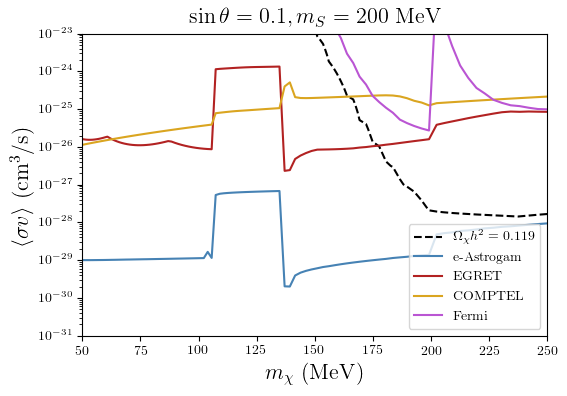

In [139]:
plt.figure(dpi=100)
plt.plot(rds_sm_1_sv[0],rds_sm_1_sv[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')
plt.plot(mxs, sm_1_e_astro, label='e-Astrogam')
plt.plot(mxs, sm_1_egret, label='EGRET')
plt.plot(mxs, sm_1_comptel, label='COMPTEL')
plt.plot(mxs, sm_1_fermi, label='Fermi')

plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-23])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\sin\theta = 0.1, m_{S} = 200 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('hp_st_1em1_ms_200.pdf')

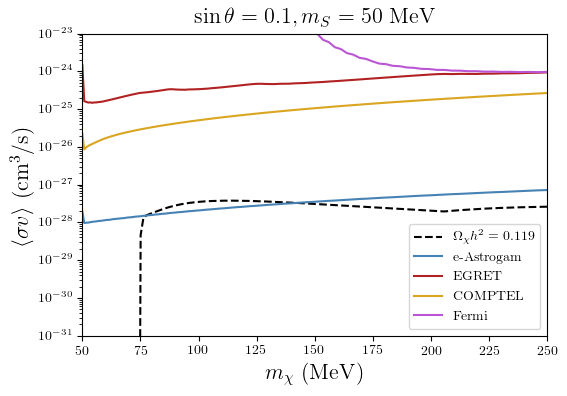

In [140]:
plt.figure(dpi=100)
plt.plot(rds_sm_2_sv[0],rds_sm_2_sv[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')
plt.plot(mxs, sm_2_e_astro, label='e-Astrogam')
plt.plot(mxs, sm_2_egret, label='EGRET')
plt.plot(mxs, sm_2_comptel, label='COMPTEL')
plt.plot(mxs, sm_2_fermi, label='Fermi')
plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-23])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\sin\theta = 0.1, m_{S} = 50 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('hp_st_1em1_ms_50.pdf')

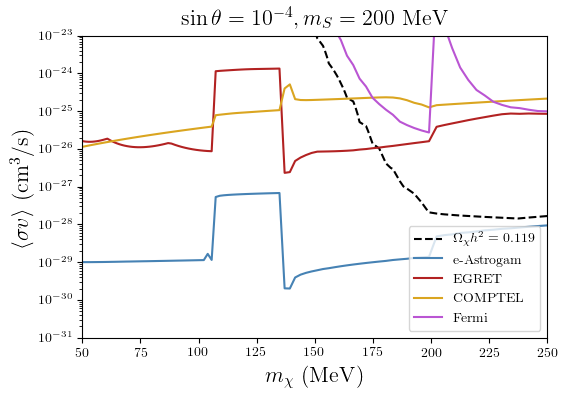

In [141]:
plt.figure(dpi=100)
plt.plot(rds_sm_3_sv[0],rds_sm_3_sv[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')
plt.plot(mxs, sm_3_e_astro, label='e-Astrogam')
plt.plot(mxs, sm_3_egret, label='EGRET')
plt.plot(mxs, sm_3_comptel, label='COMPTEL')
plt.plot(mxs, sm_3_fermi, label='Fermi')
plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-23])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\sin\theta = 10^{-4}, m_{S} = 200 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('hp_st_1em4_ms_200.pdf')

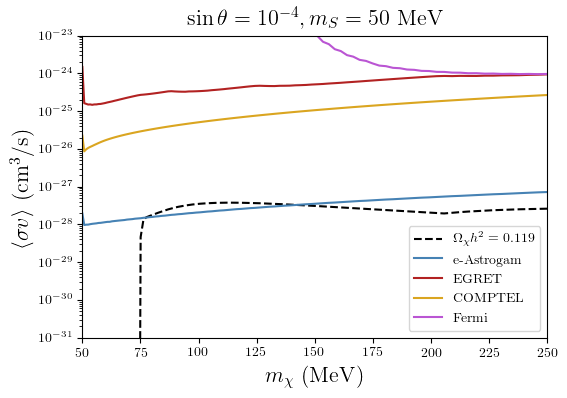

In [142]:
plt.figure(dpi=100)
plt.plot(rds_sm_4_sv[0],rds_sm_4_sv[1],'k--', label=r'$\Omega_{\chi}h^2=0.119$')
plt.plot(mxs, sm_4_e_astro, label='e-Astrogam')
plt.plot(mxs, sm_4_egret, label='EGRET')
plt.plot(mxs, sm_4_comptel, label='COMPTEL')
plt.plot(mxs, sm_4_fermi, label='Fermi')
plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-23])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\sin\theta = 10^{-4}, m_{S} = 50 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('hp_st_1em4_ms_50.pdf')

## Vector Mediator

### $\langle\sigma v\rangle$

In [65]:
def sigmav_xx_to_v_to_pipi(self):
    if self.mx < mpi:
        return 0.0
    return (((self.gvdd - self.gvuu)**2*self.gvxx**2*(-mpi**2 + self.mx**2)**1.5)/
            (4.*self.mx*np.pi*((self.mv**2 - 4*self.mx**2)**2 + self.mv**2*self.width_v**2)))

def sigmav_xx_to_v_to_pi0g(self):
    if self.mx < mpi0:
        return 0.0
    return (-((self.gvdd + 2*self.gvuu)**2*self.gvxx**2*(mpi0**2 - 4*self.mx**2)**3*qe**2)/
            (18432.*fpi**2*self.mx**2*np.pi**5*((self.mv**2 - 4*self.mx**2)**2 + self.mv**2*self.width_v**2)))

def sigmav_xx_to_v_to_pi0v(self):
    if 2.0 * self.mx < mpi0 + self.mv:
        return 0.0
    return (-((self.gvdd - self.gvuu)**2*(self.gvdd + self.gvuu)**2*self.gvxx**2*
              (mpi0**2*self.mv**2*(mpi0**2 + self.mv**2) - 2*
               (2*mpi0**4 + 4*mpi0**2*self.mv**2 + self.mv**4)*self.mx**2 + 16*
               (2*mpi0**2 + self.mv**2)*self.mx**4 - 64*self.mx**6))/
            (8192.*fpi**2*self.mx**4*
             np.sqrt(1/(mpi0**4 + (self.mv**2 - 4*self.mx**2)**2 - 2*mpi0**2*(self.mv**2 + 4*self.mx**2)))*
             np.pi**5*((self.mv**2 - 4*self.mx**2)**2 + self.mv**2*self.width_v**2)))

def sigmav_xx_to_v_to_mumu(self):
    gvll = self.gvmumu
    ml = mmu
    if self.mx < mmu:
        return 0.0
    return ((gvll**2*self.gvxx**2*np.sqrt(-ml**2 + self.mx**2)*(ml**2 + 2*self.mx**2))/
            (2.*self.mx*np.pi*((self.mv**2 - 4*self.mx**2)**2 + self.mv**2*self.width_v**2)))

def sigmav_xx_to_v_to_ee(self):
    gvll = self.gvee
    ml = me
    if self.mx < me:
        return 0.0
    return ((gvll**2*self.gvxx**2*np.sqrt(-ml**2 + self.mx**2)*(ml**2 + 2*self.mx**2))/
            (2.*self.mx*np.pi*((self.mv**2 - 4*self.mx**2)**2 + self.mv**2*self.width_v**2)))

def sigmav_xx_to_vv(self):
    if self.mx < self.mv:
        return 0.0
    return ((self.gvxx**4*(-self.mv**2 + self.mx**2)**1.5)/
            (2.*self.mx*(-self.mv**2 + 2*self.mx**2)**2*np.pi))

def sigmav_vm(self):
    conversion = 1.0 / 5.08e10 ** 2 * 3e10
    return conversion*(sigmav_xx_to_v_to_pipi(self) +
                       sigmav_xx_to_v_to_pi0g(self) +
                       sigmav_xx_to_v_to_pi0v(self) +
                       sigmav_xx_to_v_to_mumu(self) +
                       sigmav_xx_to_v_to_ee(self) +
                       sigmav_xx_to_vv(self))

### Generate Data

In [105]:
km_params_1 = {'mv': 200.0, 'eps': 0.1}
km_params_2 = {'mv': 100.0, 'eps': 0.1}
km_params_3 = {'mv': 200.0, 'eps': 1e-4}
km_params_4 = {'mv': 100.0, 'eps': 1e-4}

mxs = np.logspace(np.log10(50), np.log10(250), num=75)
gvxx_max = np.sqrt(4.0 * np.pi)
gvxx_min = 1e-4
gvxxs = np.linspace(gvxx_min, gvxx_max, num=75)

In [106]:
rds_km_1 = np.zeros((len(gvxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gvxx in enumerate(gvxxs):
        km = KineticMixing(mx, km_params_1['mv'], gvxx, km_params_1['eps'])
        rds_km_1[i,j] = km.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


In [107]:
rds_km_2 = np.zeros((len(gvxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gvxx in enumerate(gvxxs):
        km = KineticMixing(mx, km_params_2['mv'], gvxx, km_params_2['eps'])
        rds_km_2[i,j] = km.relic_density()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


In [109]:
rds_km_3 = np.zeros((len(gvxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gvxx in enumerate(gvxxs):
        km = KineticMixing(mx, km_params_3['mv'], gvxx, km_params_3['eps'])
        rds_km_3[i,j] = km.relic_density()

ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__sigmav_xx_to_v_to_ee'
ZeroDivisionError: float division
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/base.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(fun(t, y), dtype=dtype)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/_ivp/radau.py:370: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.asarray(jac(t, y), dtype=float)


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_relic_density.__thermal_cs'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py", line 450, in _quad
    return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
rds_km_4 = np.zeros((len(gvxxs), len(mxs)))
for i, mx in enumerate(mxs):
    for j, gvxx in enumerate(gvxxs):
        km = KineticMixing(mx, km_params_4['mv'], gvxx, km_params_4['eps'])
        rds_km_4[i,j] = km.relic_density()

In [110]:
np.savetxt('rd_data/rd_vm_1.txt', rds_km_1,delimiter=',')
np.savetxt('rd_data/rd_vm_2.txt', rds_km_2,delimiter=',')
np.savetxt('rd_data/rd_vm_3.txt', rds_km_3,delimiter=',')
np.savetxt('rd_data/rd_vm_4.txt', rds_km_4,delimiter=',')

### Generate Contours

In [112]:
rds_km_1_fixed=fix_contours(find_contours(rds_km_1.T, 0.119), mxs, gvxxs)
rds_km_2_fixed=fix_contours(find_contours(rds_km_2.T, 0.119), mxs, gvxxs)
rds_km_3_fixed=fix_contours(find_contours(rds_km_3.T, 0.119), mxs, gvxxs)
rds_km_4_fixed=fix_contours(find_contours(rds_km_4.T, 0.119), mxs, gvxxs)

In [116]:
rds_km_1_fixed=fix_contours(find_contours(rds_km_1.T, 0.119), mxs, gvxxs)
rds_km_2_fixed=fix_contours(find_contours(rds_km_2.T, 0.119), mxs, gvxxs)
rds_km_3_fixed=fix_contours(find_contours(rds_km_3.T, 0.119), mxs, gvxxs)
rds_km_4_fixed=fix_contours(find_contours(rds_km_4.T, 0.119), mxs, gvxxs)

rds_km_1_sv = np.array(rds_km_1_fixed)
km.mv = 200.0
km.eps = 0.1
for c in rds_km_1_sv:
    for j, val in enumerate(zip(c[0], c[1])):
        km.mx = val[0]
        km.gvxx = val[1]
        c[1][j] = sigmav_vm(km)
    
rds_km_2_sv = np.array(rds_km_2_fixed)
km.mv = 50.0
km.eps = 0.1
for c in rds_km_2_sv:
    for j, val in enumerate(zip(c[0], c[1])):
        km.mx = val[0]
        km.gvxx = val[1]
        c[1][j] = sigmav_vm(km)
        
rds_km_3_sv = np.array(rds_km_3_fixed)
km.mv = 200.0
km.eps = 1e-4
for c in rds_km_3_sv:
    for j, val in enumerate(zip(c[0], c[1])):
        km.mx = val[0]
        km.gvxx = val[1]
        c[1][j] = sigmav_vm(km)
        
rds_km_4_sv = np.array(rds_km_4_fixed)
km.mv = 50.0
km.eps = 1e-4
for c in rds_km_4_sv:
    for j, val in enumerate(zip(c[0], c[1])):
        km.mx = val[0]
        km.gvxx = val[1]
        c[1][j] = sigmav_vm(km)

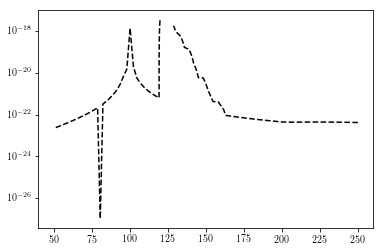

In [114]:
for c in rds_km_1_fixed:
    plt.plot(c[0],c[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')

plt.yscale('log')

### Generate Telescope Constraints

In [118]:
e_asto_params = (A_eff_e_astrogam,
                 energy_res_e_astrogam,
                 T_obs_e_astrogam,
                 gc_target,
                 gc_bg_model)

In [119]:
km.eps = 0.1
km.mv = 200.0
km.gvxx = 1.0

vm_1_e_astro = np.zeros_like(mxs)
vm_1_egret = np.zeros_like(mxs)
vm_1_comptel = np.zeros_like(mxs)
vm_1_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    km.mx = mx
    vm_1_e_astro[i] = km.unbinned_limit(*e_asto_params)
    vm_1_egret[i] = km.binned_limit(egret_diffuse)
    vm_1_comptel[i] = km.binned_limit(comptel_diffuse)
    vm_1_fermi[i] = km.binned_limit(fermi_diffuse)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/decay.py:56: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.SpectrumPoint(photon_energies, muon_energy)


In [120]:
km.eps = 0.1
km.mv = 50.0
km.gvxx = 1.0

vm_2_e_astro = np.zeros_like(mxs)
vm_2_egret = np.zeros_like(mxs)
vm_2_comptel = np.zeros_like(mxs)
vm_2_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    km.mx = mx
    vm_2_e_astro[i] = km.unbinned_limit(*e_asto_params)
    vm_2_egret[i] = km.binned_limit(egret_diffuse)
    vm_2_comptel[i] = km.binned_limit(comptel_diffuse)
    vm_2_fermi[i] = km.binned_limit(fermi_diffuse)

KeyboardInterrupt: 

Exception ignored in: 'hazma.vector_mediator.vector_mediator_decay_spectrum.__interp_spec'
Traceback (most recent call last):
  File "/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/numpy/lib/function_base.py", line 1282, in interp
    @array_function_dispatch(_interp_dispatcher)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
km.eps = 1e-4
km.mv = 200.0
km.gvxx = 1.0

vm_3_e_astro = np.zeros_like(mxs)
vm_3_egret = np.zeros_like(mxs)
vm_3_comptel = np.zeros_like(mxs)
vm_3_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    km.mx = mx
    vm_3_e_astro[i] = km.unbinned_limit(*e_asto_params)
    vm_3_egret[i] = km.binned_limit(egret_diffuse)
    vm_3_comptel[i] = km.binned_limit(comptel_diffuse)
    vm_3_fermi[i] = km.binned_limit(fermi_diffuse)

In [ ]:
km.eps = 1e-4
km.mv = 50.0
km.gvxx = 1.0

vm_4_e_astro = np.zeros_like(mxs)
vm_4_egret = np.zeros_like(mxs)
vm_4_comptel = np.zeros_like(mxs)
vm_4_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    km.mx = mx
    vm_4_e_astro[i] = km.unbinned_limit(*e_asto_params)
    vm_4_egret[i] = km.binned_limit(egret_diffuse)
    vm_4_comptel[i] = km.binned_limit(comptel_diffuse)
    vm_4_fermi[i] = km.binned_limit(fermi_diffuse)

### Plots

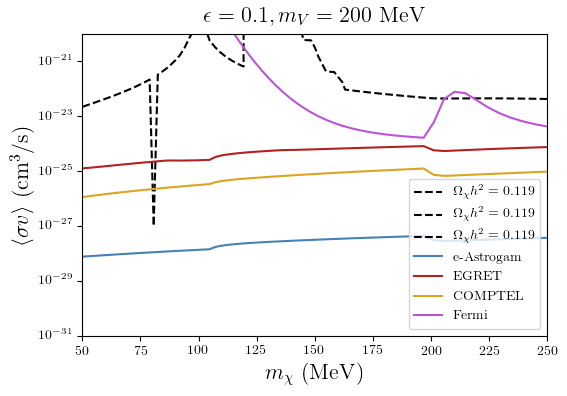

In [121]:
plt.figure(dpi=100)

for c in rds_km_1_sv:
    plt.plot(c[0],c[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')

plt.plot(mxs, vm_1_e_astro, label='e-Astrogam')
plt.plot(mxs, vm_1_egret, label='EGRET')
plt.plot(mxs, vm_1_comptel, label='COMPTEL')
plt.plot(mxs, vm_1_fermi, label='Fermi')

plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-20])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\epsilon = 0.1, m_{V} = 200 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('km_eps_1em1_mv_200.pdf')

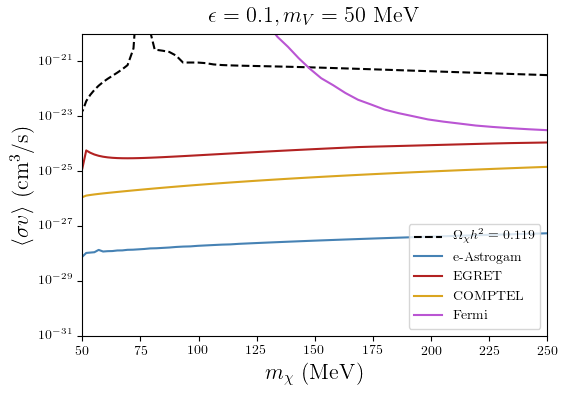

In [100]:
plt.figure(dpi=100)

for c in rds_km_2_sv:
    plt.plot(c[0],c[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')

plt.plot(mxs, vm_2_e_astro, label='e-Astrogam')
plt.plot(mxs, vm_2_egret, label='EGRET')
plt.plot(mxs, vm_2_comptel, label='COMPTEL')
plt.plot(mxs, vm_2_fermi, label='Fermi')

plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-20])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\epsilon = 0.1, m_{V} = 50 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('km_eps_1em1_mv_50.pdf')

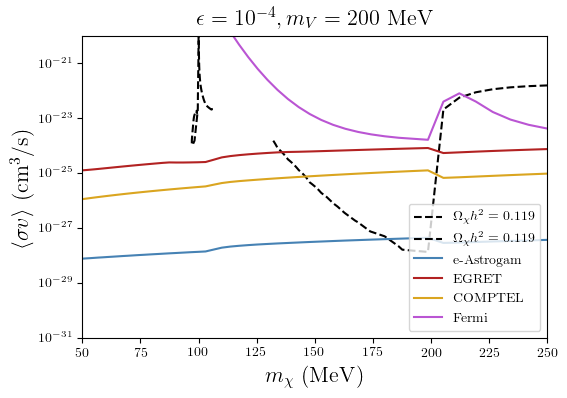

In [101]:
plt.figure(dpi=100)

for c in rds_km_3_sv:
    plt.plot(c[0],c[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')

plt.plot(mxs, vm_1_e_astro, label='e-Astrogam')
plt.plot(mxs, vm_1_egret, label='EGRET')
plt.plot(mxs, vm_1_comptel, label='COMPTEL')
plt.plot(mxs, vm_1_fermi, label='Fermi')

plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-20])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\epsilon = 10^{-4}, m_{V} = 200 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('km_eps_1em4_mv_200.pdf')

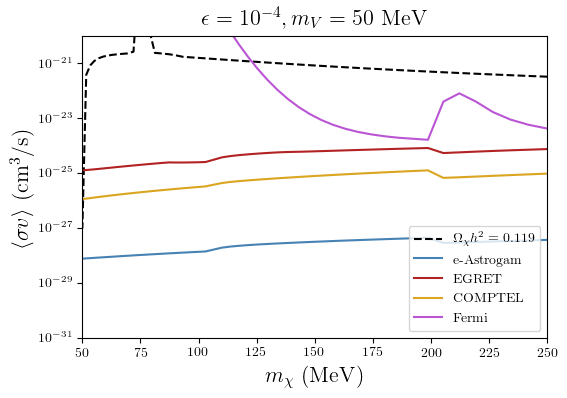

In [102]:
plt.figure(dpi=100)

for c in rds_km_4_sv:
    plt.plot(c[0],c[1], 'k--', label=r'$\Omega_{\chi}h^2=0.119$')

plt.plot(mxs, vm_1_e_astro, label='e-Astrogam')
plt.plot(mxs, vm_1_egret, label='EGRET')
plt.plot(mxs, vm_1_comptel, label='COMPTEL')
plt.plot(mxs, vm_1_fermi, label='Fermi')

plt.yscale('log')
plt.xlim([50, 250])
plt.ylim([1e-31, 1e-20])
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$', fontsize=16)
plt.title(r'$\epsilon = 10^{-4}, m_{V} = 50 \ \mathrm{MeV}$', fontsize=16)
plt.legend()
plt.savefig('km_eps_1em4_mv_50.pdf')